In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
# Ignore all runtime warnings
warnings.filterwarnings("ignore")

# Part 1: Data

In [194]:
macro_data = pd.read_excel('macro_data.xlsx',sheet_name='macro',index_col=0).fillna(method='ffill')
macro_data.index=pd.to_datetime(macro_data.index)
macro_data = macro_data['2012':]
macro_data

,XAU BGN Curncy,SPY US Equity,DXY Curncy,GSG US Equity,DWRTFT Index,SXXP Index,AAXJ US Equity,LATAM Index
2012-01-02,1566.37,100.1333,80.280,32.98,5384.21,247.15,39.7144,1451.44
2012-01-03,1603.95,101.7250,79.611,34.16,5425.54,251.06,40.7808,1496.95
2012-01-04,1611.95,101.8886,80.129,34.32,5330.74,249.62,40.4864,1506.21
2012-01-05,1622.71,102.1599,80.936,33.80,5389.45,247.39,40.4864,1484.97
2012-01-06,1617.08,101.8966,81.254,33.95,5363.27,247.53,40.1282,1475.40
...,...,...,...,...,...,...,...,...
2024-04-24,2316.17,505.4100,105.857,22.53,11735.83,505.61,67.4100,1010.50
2024-04-25,2332.46,503.4900,105.598,22.71,11664.54,502.38,67.6800,1009.82
2024-04-26,2337.96,508.2600,105.938,22.67,11676.50,507.98,68.3600,1028.22
2024-04-29,2335.66,510.0600,105.579,22.59,11791.57,508.34,68.9800,1039.64


In [195]:
fund_data = pd.read_excel('fund_historical_returns.xlsx',sheet_name='Sheet1',index_col=0)
fund_data.index=pd.to_datetime(fund_data.index)
fund_data = fund_data.sort_values(by='Date', ascending=True)
fund_data = fund_data['2012':'2024-04']
fund_data

,Price
Date,
2012-01-02,10.047430
2012-01-03,10.047430
2012-01-04,10.047430
2012-01-05,10.057430
2012-01-06,10.067430
...,...
2024-04-24,13.690318
2024-04-25,13.670318
2024-04-26,13.680318


In [196]:
data = pd.merge(fund_data, macro_data, left_index=True, right_index=True).loc[:,['Price', 'XAU BGN Curncy','SPY US Equity']]
data = data.rename(columns={'Price': 'Fund','XAU BGN Curncy':'Gold','SPY US Equity':'SP500'})
data

,Fund,Gold,SP500
Date,,,
2012-01-02,10.047430,1566.37,100.1333
2012-01-03,10.047430,1603.95,101.7250
2012-01-04,10.047430,1611.95,101.8886
2012-01-05,10.057430,1622.71,102.1599
2012-01-06,10.067430,1617.08,101.8966
...,...,...,...
2024-04-24,13.690318,2316.17,505.4100
2024-04-25,13.670318,2332.46,503.4900
2024-04-26,13.680318,2337.96,508.2600


In [197]:
data_commodity = pd.merge(fund_data, macro_data, left_index=True, right_index=True).loc[:,['Price', 'GSG US Equity','SPY US Equity']]
data_commodity= data_commodity.rename(columns={'Price': 'Fund','GSG US Equity':'Commodity','SPY US Equity':'SP500'})
data_commodity

,Fund,Commodity,SP500
Date,,,
2012-01-02,10.047430,32.98,100.1333
2012-01-03,10.047430,34.16,101.7250
2012-01-04,10.047430,34.32,101.8886
2012-01-05,10.057430,33.80,102.1599
2012-01-06,10.067430,33.95,101.8966
...,...,...,...
2024-04-24,13.690318,22.53,505.4100
2024-04-25,13.670318,22.71,503.4900
2024-04-26,13.680318,22.67,508.2600


In [198]:
data.isna().sum()

Fund     0
Gold     0
SP500    0
dtype: int64

In [199]:
def performance_summary(return_data, annualization = 252):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 

        Notes:
            The Sharpe ratio in this case does not take away any risk-free rate!
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [251]:
performance_summary(fund_data.pct_change())


,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Price,0.024489,0.024526,0.998461,-6.908253,145.159032,-0.001773,-0.003388,-0.11306,2020-02-19,2020-03-23,2020-11-09


# Part 2: Examine the correlation between all three assets to see whether we could diversify the original fund by adding S&P and Commodity

### Gold, SP, Fund

In [201]:
def calculate_directional_percentages_1(df, start_date, end_date):
    
    df = df.loc[start_date:end_date]
    
    # Calculate rolling 2-month returns assuming about 21 trading days per month, adjusted to 63 days (approx. 3 months)
    rolling_window = 63
    df['Gold_Returns'] = df['Gold'].pct_change(periods=rolling_window)
    df['Fund_Returns'] = df['Fund'].pct_change(periods=rolling_window)
    df['SP500_Returns'] = df['SP500'].pct_change(periods=rolling_window)

    # Determine the direction of returns
    df['Gold_Direction'] = np.sign(df['Gold_Returns'])
    df['Fund_Direction'] = np.sign(df['Fund_Returns'])
    df['SP500_Direction'] = np.sign(df['SP500_Returns'])

    # Scenarios for direction agreement
    # All in the same positive direction
    df['All_Positive_Direction'] = ((df['Gold_Direction'] == 1) & 
                                    (df['Fund_Direction'] == 1) & 
                                    (df['SP500_Direction'] == 1)).astype(int)

    # All in the same negative direction
    df['All_Negative_Direction'] = ((df['Gold_Direction'] == -1) & 
                                    (df['Fund_Direction'] == -1) & 
                                    (df['SP500_Direction'] == -1)).astype(int)

    # Two the same, one opposite
    df['Gold_Diff'] = ((df['Gold_Direction'] != df['Fund_Direction']) & 
                       (df['Gold_Direction'] != df['SP500_Direction']) & 
                       (df['Fund_Direction'] == df['SP500_Direction'])).astype(int)

    df['Fund_Diff'] = ((df['Fund_Direction'] != df['Gold_Direction']) & 
                       (df['Fund_Direction'] != df['SP500_Direction']) & 
                       (df['Gold_Direction'] == df['SP500_Direction'])).astype(int)

    df['SP500_Diff'] = ((df['SP500_Direction'] != df['Gold_Direction']) & 
                        (df['SP500_Direction'] != df['Fund_Direction']) & 
                        (df['Gold_Direction'] == df['Fund_Direction'])).astype(int)

    # Calculate percentages
    percentage_all_positive = df['All_Positive_Direction'].mean() * 100
    percentage_all_negative = df['All_Negative_Direction'].mean() * 100
    percentage_gold_diff = df['Gold_Diff'].mean() * 100
    percentage_fund_diff = df['Fund_Diff'].mean() * 100
    percentage_sp500_diff = df['SP500_Diff'].mean() * 100

    # Create DataFrame to return results
    results_df = pd.DataFrame({
        'Scenario': ['All Positive Direction', 'All Negative Direction', 'Gold Different', 'Fund Different', 'S&P 500 Different'],
        'Percentage': [percentage_all_positive, percentage_all_negative, percentage_gold_diff, percentage_fund_diff, percentage_sp500_diff]
    })

    return results_df


In [202]:
start_date = '2020'
end_date = '2024'

In [203]:
results_df = calculate_directional_percentages_1(data, start_date, end_date)
results_df

,Scenario,Percentage
0,All Positive Direction,37.079646
1,All Negative Direction,10.353982
2,Gold Different,35.575221
3,Fund Different,6.460177
4,S&P 500 Different,4.955752


### Commodity, SP, Fund

In [204]:

def calculate_directional_percentages_2(df, start_date, end_date):
    # Filter data for the specified date range
    df = df.loc[start_date:end_date]
    
    # Calculate rolling 2-month returns assuming about 21 trading days per month, adjusted to 63 days (approx. 3 months)
    rolling_window = 63
    df['Commodity_Returns'] = df['Commodity'].pct_change(periods=rolling_window)
    df['Fund_Returns'] = df['Fund'].pct_change(periods=rolling_window)
    df['SP500_Returns'] = df['SP500'].pct_change(periods=rolling_window)

    # Determine the direction of returns
    df['Commodity_Direction'] = np.sign(df['Commodity_Returns'])
    df['Fund_Direction'] = np.sign(df['Fund_Returns'])
    df['SP500_Direction'] = np.sign(df['SP500_Returns'])

    # Scenarios for direction agreement
    # All in the same positive direction
    df['All_Positive_Direction'] = ((df['Commodity_Direction'] == 1) & 
                                    (df['Fund_Direction'] == 1) & 
                                    (df['SP500_Direction'] == 1)).astype(int)

    # All in the same negative direction
    df['All_Negative_Direction'] = ((df['Commodity_Direction'] == -1) & 
                                    (df['Fund_Direction'] == -1) & 
                                    (df['SP500_Direction'] == -1)).astype(int)

    # Two the same, one opposite
    df['Commodity_Diff'] = ((df['Commodity_Direction'] != df['Fund_Direction']) & 
                            (df['Commodity_Direction'] != df['SP500_Direction']) & 
                            (df['Fund_Direction'] == df['SP500_Direction'])).astype(int)

    df['Fund_Diff'] = ((df['Fund_Direction'] != df['Commodity_Direction']) & 
                       (df['Fund_Direction'] != df['SP500_Direction']) & 
                       (df['Commodity_Direction'] == df['SP500_Direction'])).astype(int)

    df['SP500_Diff'] = ((df['SP500_Direction'] != df['Commodity_Direction']) & 
                        (df['SP500_Direction'] != df['Fund_Direction']) & 
                        (df['Commodity_Direction'] == df['Fund_Direction'])).astype(int)

    # Calculate percentages
    percentage_all_positive = df['All_Positive_Direction'].mean() * 100
    percentage_all_negative = df['All_Negative_Direction'].mean() * 100
    percentage_commodity_diff = df['Commodity_Diff'].mean() * 100
    percentage_fund_diff = df['Fund_Diff'].mean() * 100
    percentage_sp500_diff = df['SP500_Diff'].mean() * 100

    # Create DataFrame to return results
    results_df = pd.DataFrame({
        'Scenario': ['All Positive Direction', 'All Negative Direction', 'Commodity Different', 'Fund Different', 'S&P 500 Different'],
        'Percentage': [percentage_all_positive, percentage_all_negative, percentage_commodity_diff, percentage_fund_diff, percentage_sp500_diff]
    })

    return results_df

In [205]:
start_date = '2022'
end_date = '2024'

In [206]:
results_df = calculate_directional_percentages_2(data_commodity, start_date, end_date)
results_df

,Scenario,Percentage
0,All Positive Direction,20.757825
1,All Negative Direction,8.731466
2,Commodity Different,53.047776
3,Fund Different,5.601318
4,S&P 500 Different,1.482702


In [207]:
start_date = '2012'
end_date = '2021'

In [208]:
results_df = calculate_directional_percentages_2(data_commodity, start_date, end_date)
results_df

,Scenario,Percentage
0,All Positive Direction,41.877395
1,All Negative Direction,10.114943
2,Commodity Different,25.823755
3,Fund Different,11.494253
4,S&P 500 Different,8.275862


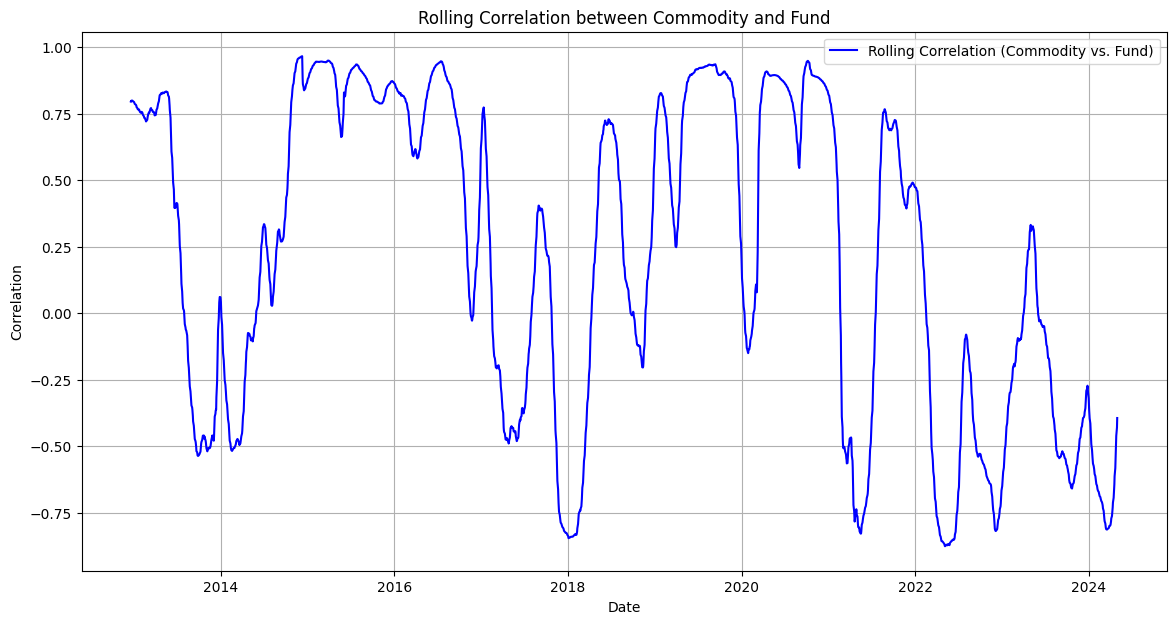

In [209]:
# Calculate rolling 2-month returns assuming about 21 trading days per month, adjusted to 63 days (approx. 3 months)
df = pd.DataFrame()
rolling_window = 126
df['Commodity_Returns'] = data_commodity['Commodity'].pct_change(periods=rolling_window)
df['Fund_Returns'] = data_commodity['Fund'].pct_change(periods=rolling_window)

# Calculate rolling correlation between Commodity and Fund
rolling_corr = df['Commodity_Returns'].rolling(window=rolling_window).corr(df['Fund_Returns'])

# Plot the rolling correlation
plt.figure(figsize=(14, 7))
plt.plot(rolling_corr, label='Rolling Correlation (Commodity vs. Fund)', color='blue')
plt.title('Rolling Correlation between Commodity and Fund')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

### During years from 2022-2024, commodity becomes a good hedge to the portfolio as only 29% of the time commodity, corporate bond and S&P moves in the same direction comparing to 51% from 2012 to 2021. Commodity also shows negative rolling 3 months correlation with the fund during recent years. Thus, we believe including commodity into the fund would boost its performance.

### Question and TODO: Why commodity has low correlation in recent years? Compare correlation with the interest rate.

# Part 3: Tangent Portfolio

In [210]:
rf_data_1 = pd.read_csv('United States 3-Month Bond Yield Historical Data.csv')
rf_data_2 = pd.read_csv('United States 3-Month Bond Yield Historical Data (1).csv')
rf_data = pd.concat([rf_data_2, rf_data_1])
rf_data['Date'] = pd.to_datetime(rf_data['Date'])

# Sort the DataFrame by 'Date' in descending order
rf_data = rf_data.iloc[::-1].reset_index(drop=True)
rf_data

,Date,Price,Open,High,Low,Change %
0,2000-01-03,5.405,5.405,5.405,5.405,3.80%
1,2000-01-04,5.379,5.379,5.379,5.379,-0.48%
2,2000-01-05,5.430,5.430,5.430,5.430,0.95%
3,2000-01-06,5.393,5.393,5.393,5.393,-0.68%
4,2000-01-07,5.375,5.375,5.375,5.375,-0.33%
...,...,...,...,...,...,...
6295,2024-04-24,5.405,5.431,5.448,5.415,0.19%
6296,2024-04-25,5.404,5.443,5.516,5.416,-0.02%
6297,2024-04-26,5.394,5.448,5.505,5.409,-0.19%
6298,2024-04-28,5.411,5.411,5.411,5.411,0.32%


In [211]:
merged_df = data_commodity.pct_change().dropna()
merged_df

,Fund,Commodity,SP500
Date,,,
2012-01-03,0.000000,0.035779,0.015896
2012-01-04,0.000000,0.004684,0.001608
2012-01-05,0.000995,-0.015152,0.002663
2012-01-06,0.000994,0.004438,-0.002577
2012-01-09,0.000000,0.001178,0.002427
...,...,...,...
2024-04-24,0.000000,-0.004419,-0.000475
2024-04-25,-0.001461,0.007989,-0.003799
2024-04-26,0.000732,-0.001761,0.009474


In [212]:
merged_df_excess = merged_df.merge(rf_data, on='Date', how='inner')
merged_df_excess.set_index('Date', inplace=True)
merged_df_excess['Price'] = merged_df_excess['Price']/(100*365)
merged_df_excess = merged_df_excess.iloc[:,0:3].sub(merged_df_excess['Price'], axis=0)
merged_df_excess

,Fund,Commodity,SP500
Date,,,
2012-01-03,-5.479452e-07,0.035779,0.015895
2012-01-04,-4.109589e-07,0.004683,0.001608
2012-01-05,9.948684e-04,-0.015152,0.002662
2012-01-06,9.938788e-04,0.004437,-0.002578
2012-01-09,-3.561644e-07,0.001178,0.002427
...,...,...,...
2024-04-23,1.315216e-03,0.005630,0.011719
2024-04-24,-1.480822e-04,-0.004567,-0.000623
2024-04-25,-1.608941e-03,0.007841,-0.003947


In [213]:
def tangency_weights(returns, cov_mat = 1):
    
    if cov_mat ==1:
        cov_inv = np.linalg.inv((returns.cov()*252))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag((cov)))
        covmat = cov_mat * cov + (1-cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat*252))  
        
    ones = np.ones(returns.columns[0:].shape) 
    mu = returns.mean()*252
    scaling = 1/(np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling*(cov_inv @ mu) 
    tangency_wts = pd.DataFrame(index = returns.columns[0:], data = tangent_return, columns = ['Tangent Weights'] )
        
    return tangency_wts

### recent years tangent

In [214]:
recent_data = merged_df_excess['2022':'2024']

In [215]:
merged_df_excess

,Fund,Commodity,SP500
Date,,,
2012-01-03,-5.479452e-07,0.035779,0.015895
2012-01-04,-4.109589e-07,0.004683,0.001608
2012-01-05,9.948684e-04,-0.015152,0.002662
2012-01-06,9.938788e-04,0.004437,-0.002578
2012-01-09,-3.561644e-07,0.001178,0.002427
...,...,...,...
2024-04-23,1.315216e-03,0.005630,0.011719
2024-04-24,-1.480822e-04,-0.004567,-0.000623
2024-04-25,-1.608941e-03,0.007841,-0.003947


In [216]:
w_t = tangency_weights(recent_data)
w_t

,Tangent Weights
Fund,1.180607
Commodity,-0.085420
SP500,-0.095187


In [217]:
w_tan_summary_statistics = performance_summary(recent_data @ w_t , annualization = 252)
w_tan_summary_statistics

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Tangent Weights,-0.023233,0.032796,-0.708387,0.24784,0.741007,-0.003305,-0.004288,-0.076318,2022-01-03,2023-10-19,NaT


In [218]:
fund_statistics = performance_summary(recent_data , annualization = 252)
fund_statistics

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Fund,-0.009159,0.023632,-0.387591,0.129196,4.411827,-0.002419,-0.003028,-0.058213,2022-01-03,2022-10-21,NaT
Commodity,0.111997,0.245049,0.457039,-0.684844,5.358072,-0.024576,-0.036161,-0.322606,2022-06-08,2023-05-31,NaT
SP500,0.029963,0.182605,0.164088,-0.076895,1.686143,-0.017745,-0.026199,-0.251036,2022-01-03,2022-10-12,2024-02-02


### Question: commodity performs good while weighting low. Probably not a good way of asset allocation

### All data tangent

In [219]:
w_t = tangency_weights(merged_df_excess)
w_t

,Tangent Weights
Fund,0.870685
Commodity,-0.100858
SP500,0.230173


In [220]:
w_tan_summary_statistics = performance_summary(merged_df_excess @ w_t , annualization = 252)
w_tan_summary_statistics

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Tangent Weights,0.046073,0.046683,0.986932,-1.244818,20.503483,-0.004078,-0.006998,-0.142369,2020-02-11,2020-03-23,2020-06-08


In [221]:
fund_statistics = performance_summary( merged_df_excess, annualization = 252)
fund_statistics

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Fund,0.016320,0.024599,0.663432,-6.875930,143.862578,-0.001774,-0.003425,-0.113470,2020-02-19,2020-03-23,2020-11-16
Commodity,-0.015463,0.207607,-0.074483,-0.700773,7.221471,-0.020700,-0.031095,-0.787718,2012-03-01,2020-04-28,NaT
SP500,0.131657,0.163516,0.805166,-0.544240,13.858549,-0.015301,-0.024947,-0.337484,2020-02-19,2020-03-23,2020-08-10


In [222]:
merged_df_excess

,Fund,Commodity,SP500
Date,,,
2012-01-03,-5.479452e-07,0.035779,0.015895
2012-01-04,-4.109589e-07,0.004683,0.001608
2012-01-05,9.948684e-04,-0.015152,0.002662
2012-01-06,9.938788e-04,0.004437,-0.002578
2012-01-09,-3.561644e-07,0.001178,0.002427
...,...,...,...
2024-04-23,1.315216e-03,0.005630,0.011719
2024-04-24,-1.480822e-04,-0.004567,-0.000623
2024-04-25,-1.608941e-03,0.007841,-0.003947


## TODO: 
1) Do OOS on risk parity strategy, using the weights to calculate future 2 month return
2) Calculate the 1 month OOS performance when all three assets move in the same direction(current cases)

In [223]:
import numpy as np
import pandas as pd


# Calculate monthly tangency weights using the previous month's data
monthly_tangency_weights = []

# Get the unique months in the index
unique_months = merged_df_excess.resample('M').last().index

for date in unique_months[1:]:  # Start from the second month
    # Previous month's end date
    previous_month_end = (date - pd.DateOffset(months=1)).to_period('M').end_time
    # Previous month's start date
    previous_month_start = (date - pd.DateOffset(months=1)).to_period('M').start_time
    previous_month_data = merged_df_excess.loc[previous_month_start:previous_month_end]
    weights = tangency_weights(previous_month_data)
    monthly_tangency_weights.append((date, weights))

# Convert the list of weights into a DataFrame
monthly_weights_df = pd.concat([w[1].assign(Date=w[0]) for w in monthly_tangency_weights])
monthly_weights_df = monthly_weights_df.reset_index().pivot(index='Date', columns='index', values='Tangent Weights')


monthly_weights_df


index,Commodity,Fund,SP500
Date,,,
2012-02-29,-0.024534,0.883380,0.141154
2012-03-31,0.061435,0.751851,0.186714
2012-04-30,-1.578722,0.163534,2.415188
2012-05-31,-0.012649,1.027722,-0.015072
2012-06-30,0.365397,0.782937,-0.148334
...,...,...,...
2023-12-31,-0.131376,0.613796,0.517580
2024-01-31,-0.127712,0.853601,0.274111
2024-02-29,-0.841370,2.622562,-0.781192


In [224]:
monthly_weights_df.mean()

index
Commodity    0.004985
Fund         0.939854
SP500        0.055161
dtype: float64

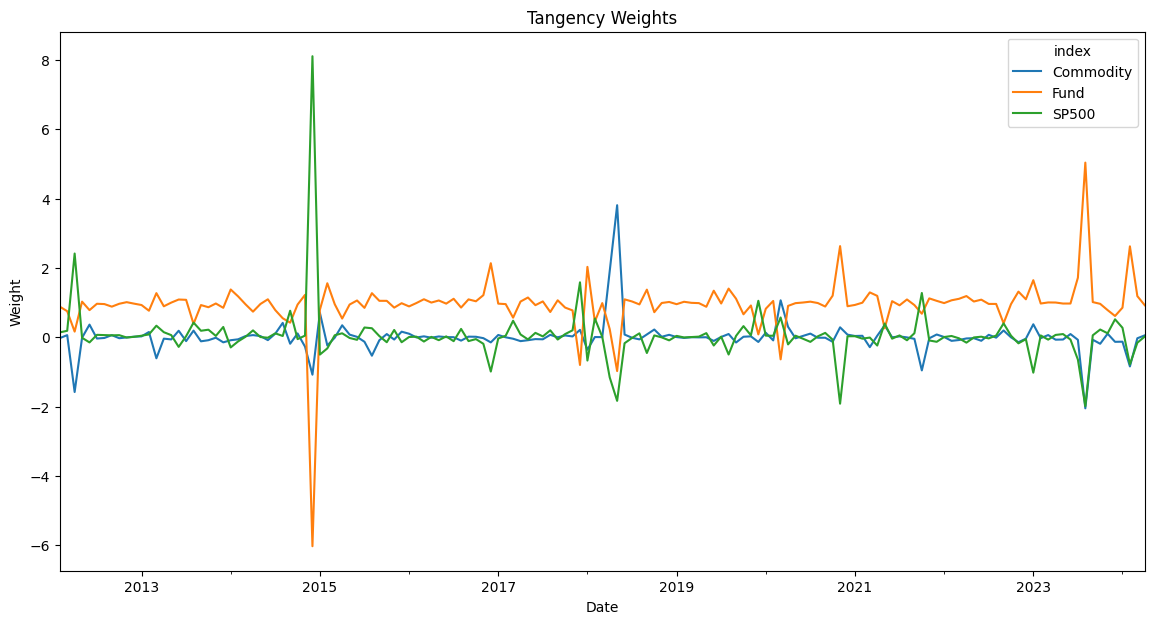

In [253]:


# Plot the weights with the figure size directly set in the plot method
monthly_weights_df.plot(title='Tangency Weights', figsize=(14, 7))
plt.ylabel('Weight')
plt.show()

In [225]:
portfolio_returns = pd.Series(index=merged_df_excess.index)

# Iterate through each month and apply the corresponding weights to the daily returns
for date, weights in monthly_weights_df.iterrows():
    # Get the start and end of the current month
    start_date = date.to_period('M').start_time
    end_date = date.to_period('M').end_time
    
    # Select the daily returns for the current month
    monthly_data = merged_df_excess.loc[start_date:end_date]
    
    # Calculate the daily portfolio returns using the current month's weights
    daily_portfolio_returns = (monthly_data * weights.values).sum(axis=1)
    
    # Store the daily portfolio returns
    portfolio_returns.loc[start_date:end_date] = daily_portfolio_returns

# Drop NaN values to get the final portfolio returns
portfolio_monthly_tan_rebal = portfolio_returns.dropna().to_frame(name='Portfolio Returns')

portfolio_monthly_tan_rebal


,Portfolio Returns
Date,
2012-02-01,0.000711
2012-02-02,-0.000302
2012-02-03,0.009358
2012-02-06,0.004035
2012-02-07,0.004257
...,...
2024-04-23,0.005519
2024-04-24,-0.004240
2024-04-25,0.007072


In [226]:
performance_summary(portfolio_monthly_tan_rebal)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Portfolio Returns,0.104635,0.267029,0.39185,2.055438,35.635764,-0.022066,-0.035479,-0.551604,2014-12-29,2020-04-28,2021-10-19


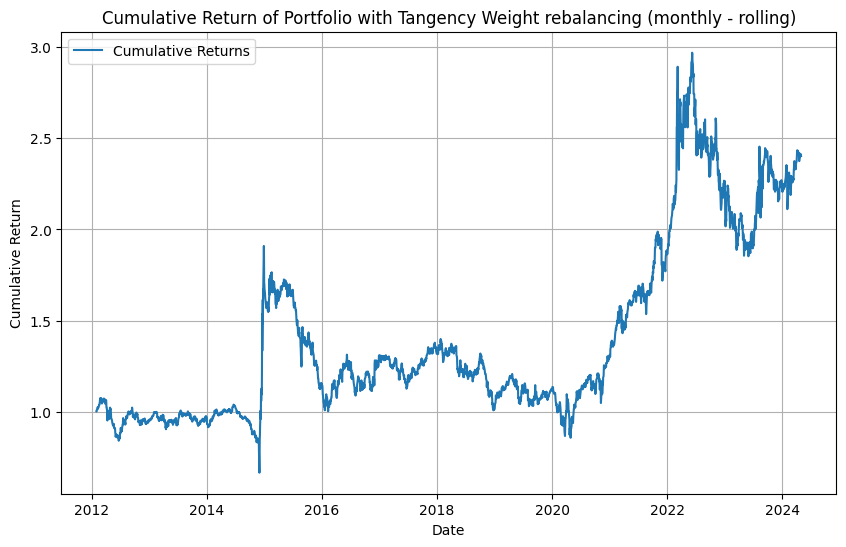

In [227]:
import matplotlib.pyplot as plt

# Calculate cumulative returns
portfolio_monthly_tan_rebal['Cumulative Returns'] = (1 + portfolio_monthly_tan_rebal['Portfolio Returns']).cumprod()

# Plot cumulative returns using matplotlib
plt.figure(figsize=(10, 6))
plt.plot( portfolio_monthly_tan_rebal['Cumulative Returns'], label='Cumulative Returns')
plt.title('Cumulative Return of Portfolio with Tangency Weight rebalancing (monthly - rolling)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [228]:
annual_tangency_weights = []

# Get the unique years in the index
unique_years = merged_df_excess.resample('A').last().index

for date in unique_years[1:]:  # Start from the second year
    # Previous year's end date
    previous_year_end = (date - pd.DateOffset(years=1)).to_period('A').end_time
    # Previous year's start date
    previous_year_start = (date - pd.DateOffset(years=1)).to_period('A').start_time
    previous_year_data = merged_df_excess.loc[previous_year_start:previous_year_end]
    weights = tangency_weights(previous_year_data)
    annual_tangency_weights.append((date, weights))

# Convert the list of weights into a DataFrame
annual_weights_df = pd.concat([w[1].assign(Date=w[0]) for w in annual_tangency_weights])
annual_weights_df = annual_weights_df.reset_index().pivot(index='Date', columns='index', values='Tangent Weights')
annual_weights_df

index,Commodity,Fund,SP500
Date,,,
2013-12-31,-0.019549,0.964727,0.054822
2014-12-31,-0.237423,0.594498,0.642925
2015-12-31,1.660404,0.536186,-1.196590
2016-12-31,0.163322,1.018662,-0.181985
2017-12-31,-0.003599,1.031740,-0.028141
2018-12-31,-0.007632,0.908796,0.098837
2019-12-31,0.026172,0.988431,-0.014603
2020-12-31,-0.001551,0.958921,0.042630
2021-12-31,-0.730557,1.123704,0.606853


In [229]:
portfolio_returns = pd.Series(index=merged_df_excess.index)

# Iterate through each year and apply the corresponding weights to the daily returns
for date, weights in annual_weights_df.iterrows():
    # Get the start and end of the current year
    start_date = date.to_period('A').start_time
    end_date = date.to_period('A').end_time
    
    # Select the daily returns for the current year
    annual_data = merged_df_excess.loc[start_date:end_date]
    
    # Calculate the daily portfolio returns using the current year's weights
    daily_portfolio_returns = (annual_data * weights.values).sum(axis=1)
    
    # Store the daily portfolio returns
    portfolio_returns.loc[start_date:end_date] = daily_portfolio_returns

# Drop NaN values to get the final portfolio returns
portfolio_annual_tan_rebal = portfolio_returns.dropna().to_frame(name='Portfolio Returns')

portfolio_annual_tan_rebal

,Portfolio Returns
Date,
2013-01-01,-0.000001
2013-01-02,0.004363
2013-01-03,-0.004835
2013-01-04,-0.001844
2013-01-07,0.005147
...,...
2024-04-23,0.009882
2024-04-24,-0.003102
2024-04-25,0.002792


In [230]:
performance_summary(portfolio_annual_tan_rebal)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Portfolio Returns,0.017872,0.1973,0.090582,-0.782655,7.418562,-0.019509,-0.029455,-0.671303,2014-06-20,2020-04-28,2022-03-02


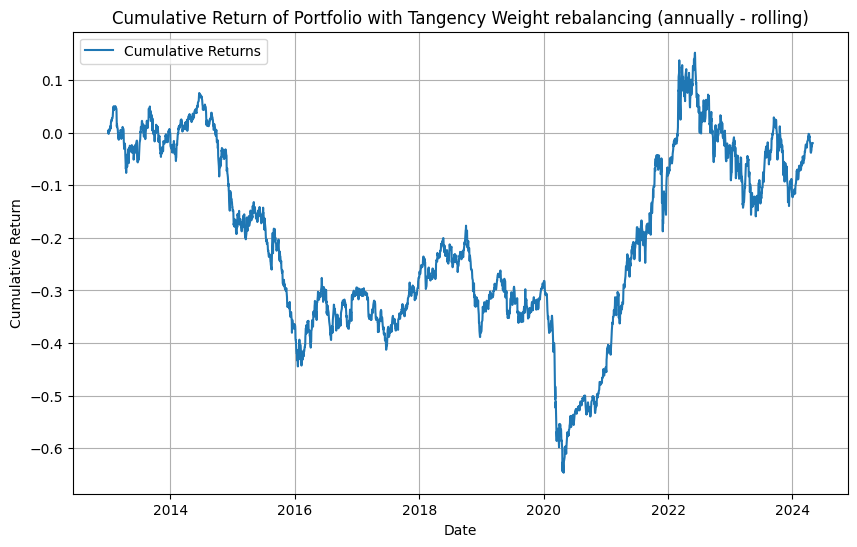

In [231]:
portfolio_annual_tan_rebal['Cumulative Returns'] = (1 + portfolio_annual_tan_rebal['Portfolio Returns']).cumprod() - 1

# Plot cumulative returns using matplotlib
plt.figure(figsize=(10, 6))
plt.plot( portfolio_annual_tan_rebal['Cumulative Returns'], label='Cumulative Returns')
plt.title('Cumulative Return of Portfolio with Tangency Weight rebalancing (annually - rolling)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [233]:
descriptions= pd.read_excel('macro_data.xlsx', sheet_name='descriptions')
descriptions

,Unnamed: 0,security_name,px_last,crncy,security_typ
0,AAXJ US Equity,iShares MSCI All Country Asia,73.430,USD,ETP
1,DWRTFT Index,Dow Jones US Select REIT Total,12358.990,USD,Equity Index
2,DXY Curncy,DOLLAR INDEX SPOT,104.474,USD,Currency spot.
3,GSG US Equity,iShares S&P GSCI Commodity-Ind,22.425,USD,ETP
4,LATAM Index,Bloomberg LATAM Large & Mid Ca,1054.410,USD,Equity Index
5,SPY US Equity,SPDR S&P 500 ETF Trust,529.110,USD,ETP
6,SXXP Index,STOXX Europe 600 Price Index E,522.940,EUR,Equity Index
7,XAU BGN Curncy,Gold,2416.090,XAU,SPOT


In [234]:
macro_assets = pd.read_excel('macro_data.xlsx', sheet_name='macro')
macro_assets.set_index('Unnamed: 0', inplace=True)
macro_assets.index.names = ['Date']

In [235]:
fund = pd.read_excel('fund_historical_returns.xlsx')
fund. head()

,Date,Price
0,05/15/2024,13.820318
1,05/14/2024,13.780318
2,05/13/2024,13.770318
3,05/10/2024,13.760318
4,05/09/2024,13.770318


In [236]:
fund['Date'] = pd.to_datetime(fund['Date'])

# Convert the index to datetime in the 'macro_assets' DataFrame
macro_assets.index = pd.to_datetime(macro_assets.index)

# Set 'Date' as the index for the 'fund' DataFrame
fund.set_index('Date', inplace=True)

# Combine the two DataFrames on the 'Date' index
assets = fund.join(macro_assets, how='inner')

# Reset index if needed
assets.reset_index(inplace=True)
assets.rename(columns={'Price': 'Fund'}, inplace=True)

In [237]:
assets = assets.sort_index(ascending=False)
assets.set_index('Date', inplace=True)

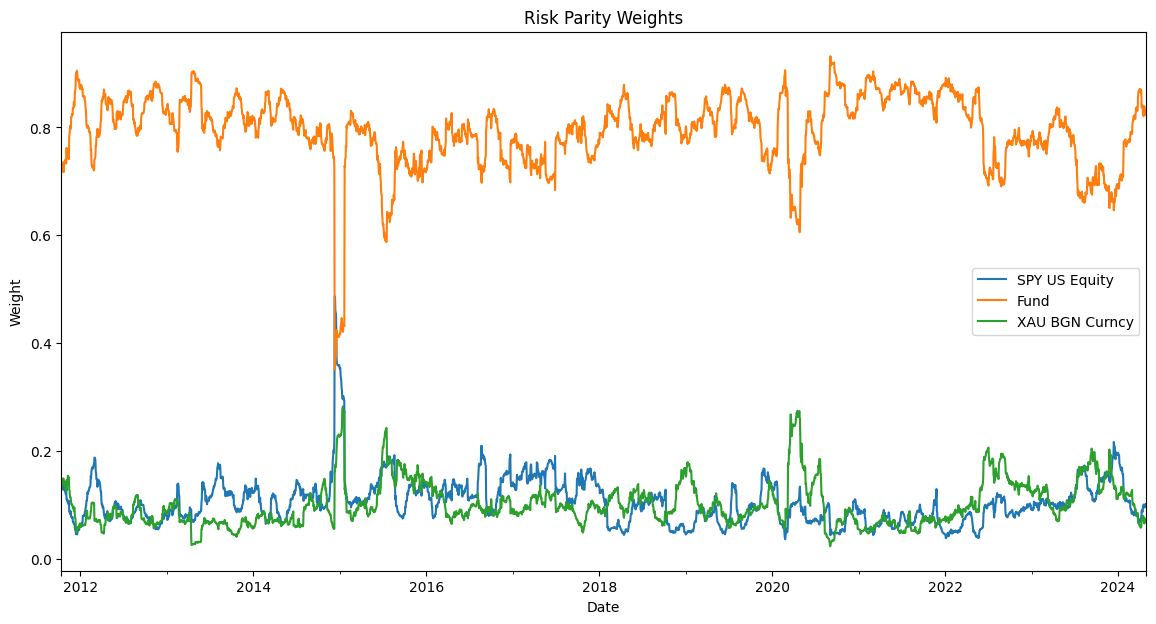

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'assets' is your combined DataFrame
# Calculate daily returns
returns = assets[['SPY US Equity', 'Fund', 'XAU BGN Curncy']]['2010':'2024'].pct_change()

# Calculate the trailing one-year standard deviation (252 trading days)
trailing_std = returns.rolling(window=30).std()

# Calculate the inverse of the trailing standard deviation to get risk parity weights
inverse_std = 1 / trailing_std

# Normalize the weights so they sum to 1
weights = inverse_std.div(inverse_std.sum(axis=1), axis=0)

# Drop NaN values resulting from the rolling window operation
weights = weights.dropna()

# Plot the weights with the figure size directly set in the plot method
weights.plot(title='Risk Parity Weights', figsize=(14, 7))
plt.ylabel('Weight')
plt.show()

<Figure size 1400x700 with 0 Axes>

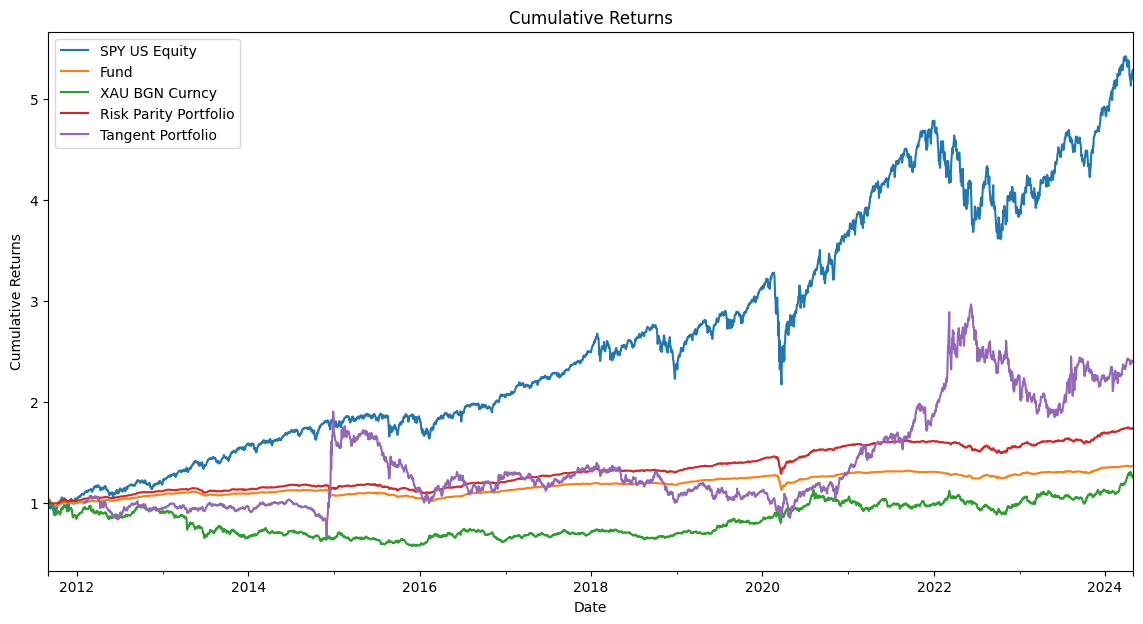

In [239]:
portfolio_returns = (weights * returns).sum(axis=1)

# Add portfolio returns to the returns DataFrame
returns['Risk Parity Portfolio'] = portfolio_returns

# Plot the cumulative returns of the portfolio and the three assets
plt.figure(figsize=(14, 7))
cumulative_returns = (1 + returns[['SPY US Equity', 'Fund', 'XAU BGN Curncy', 'Risk Parity Portfolio']]).cumprod()
aligned_cumulative_returns = portfolio_monthly_tan_rebal['Cumulative Returns'].reindex(cumulative_returns.index).fillna(method='ffill')
cumulative_returns =cumulative_returns.rename(columns={'Portfolio': 'Risk Parity Portfolio'})
# Merge aligned cumulative returns into cumulative_returns DataFrame

cumulative_returns['Tangent Portfolio'] = aligned_cumulative_returns
cumulative_returns.plot(title='Cumulative Returns', figsize=(14, 7))
plt.plot( portfolio_monthly_tan_rebal['Cumulative Returns'], label='Cumulative Returns')
plt.ylabel('Cumulative Returns')
plt.show()

In [240]:
portfolio_monthly_tan_rebal['Portfolio Returns']

Date
2012-02-01    0.000711
2012-02-02   -0.000302
2012-02-03    0.009358
2012-02-06    0.004035
2012-02-07    0.004257
                ...   
2024-04-23    0.005519
2024-04-24   -0.004240
2024-04-25    0.007072
2024-04-26   -0.001536
2024-04-29   -0.003293
Name: Portfolio Returns, Length: 3173, dtype: float64

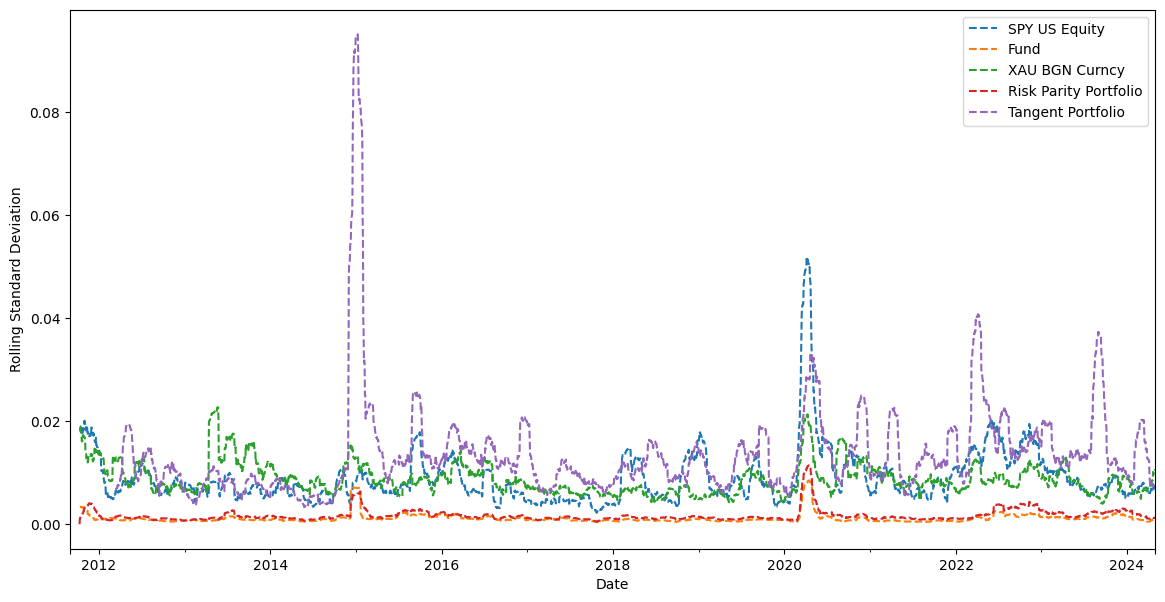

In [241]:
portfolio_monthly_tan_rebal_aligned = portfolio_monthly_tan_rebal['Portfolio Returns'].reindex(returns.index).fillna(method='ffill')

# Add the aligned 'Portfolio Returns' as 'Tangent' to the returns DataFrame
returns['Tangent Portfolio'] = portfolio_monthly_tan_rebal_aligned
rolling_portfolio_std = returns.rolling(window=30).std()

# Plot the rolling standard deviations of the three assets and the portfolio
plt.figure(figsize=(14, 7))

rolling_portfolio_std.plot(ax=plt.gca(), linestyle='--', label='Portfolio Rolling Std')

plt.ylabel('Rolling Standard Deviation')
plt.legend()
plt.show()

In [242]:
performance_summary(returns)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
SPY US Equity,0.139804,0.166582,0.839252,-0.500919,12.573429,-0.015951,-0.025444,-0.337174,2020-02-19,2020-03-23,2020-08-10
Fund,0.024215,0.024901,0.972421,-6.527355,133.521472,-0.001808,-0.003501,-0.113060,2020-02-19,2020-03-23,2020-11-09
XAU BGN Curncy,0.028244,0.148658,0.189995,-0.452779,5.672404,-0.014978,-0.022112,-0.446848,2011-09-05,2015-12-17,2020-07-24
Risk Parity Portfolio,0.042774,0.033428,1.279584,-1.620636,33.875723,-0.002742,-0.004718,-0.117079,2020-02-21,2020-03-20,2020-06-23
Tangent Portfolio,0.106027,0.266353,0.398071,2.055268,35.758975,-0.022013,-0.035395,-0.559124,2014-12-29,2020-04-28,2021-10-20


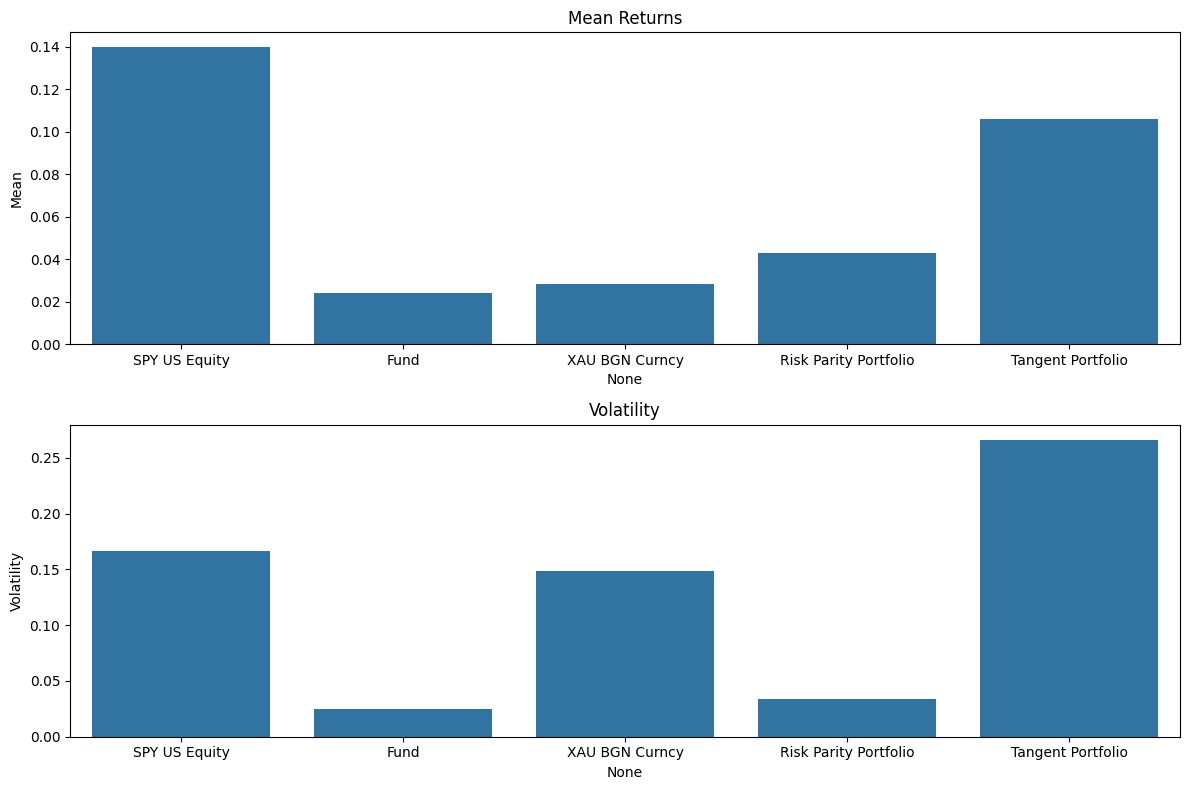

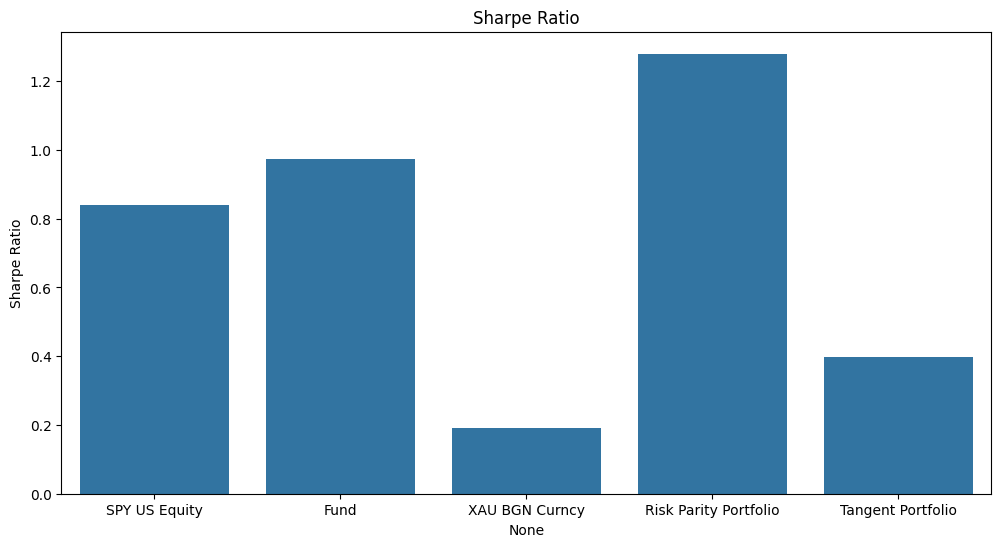

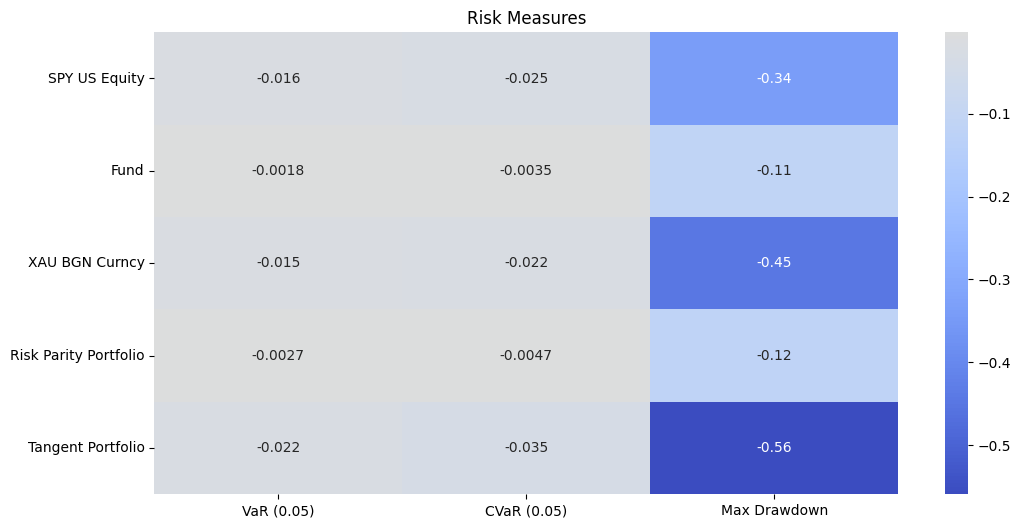

In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = performance_summary(returns)

# 1. Bar Plots for Mean and Volatility
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
sns.barplot(x=df.index, y='Mean', data=df, ax=axes[0])
axes[0].set_title('Mean Returns')
axes[0].set_ylabel('Mean')

sns.barplot(x=df.index, y='Volatility', data=df, ax=axes[1])
axes[1].set_title('Volatility')
axes[1].set_ylabel('Volatility')

plt.tight_layout()
plt.show()

# 2. Bar Plot for Sharpe Ratio
plt.figure(figsize=(12, 6))
sns.barplot(x=df.index, y='Sharpe Ratio', data=df)
plt.title('Sharpe Ratio')
plt.ylabel('Sharpe Ratio')
plt.show()

# 3. Heatmap for Risk Measures
risk_measures = df[['VaR (0.05)', 'CVaR (0.05)', 'Max Drawdown']]
plt.figure(figsize=(12, 6))
sns.heatmap(risk_measures, annot=True, cmap='coolwarm', center=0)
plt.title('Risk Measures')
plt.show()

# 4. Radar Chart (example using Plotly, requires additional setup)
import plotly.express as px

# Preparing data for radar chart
radar_df = df[['Mean', 'Volatility', 'Sharpe Ratio', 'Skewness', 'Excess Kurtosis']].reset_index()
radar_df = pd.melt(radar_df, id_vars=['index'], var_name='Metric', value_name='Value')

fig = px.line_polar(radar_df, r='Value', theta='Metric', color='index', line_close=True)
fig.update_layout(title='Performance Metrics Radar Chart')
fig.show()


In [244]:
def calculate_directional_percentages_and_risk_parity_gold(df, start_date, end_date):
    # Filter data for the specified date range
    df = df.loc[start_date:end_date]
    
    # Calculate daily returns
    df['Gold_Returns'] = df['Gold'].pct_change()
    df['Fund_Returns'] = df['Fund'].pct_change()
    df['SP500_Returns'] = df['SP500'].pct_change()

    # Calculate rolling 2-month returns assuming about 21 trading days per month, adjusted to 63 days (approx. 3 months)
    rolling_window = 30
    df['Gold_Rolling_Returns'] = df['Gold'].pct_change(periods=rolling_window)
    df['Fund_Rolling_Returns'] = df['Fund'].pct_change(periods=rolling_window)
    df['SP500_Rolling_Returns'] = df['SP500'].pct_change(periods=rolling_window)

    # Determine the direction of rolling returns
    df['Gold_Direction'] = np.sign(df['Gold_Rolling_Returns'])
    df['Fund_Direction'] = np.sign(df['Fund_Rolling_Returns'])
    df['SP500_Direction'] = np.sign(df['SP500_Rolling_Returns'])

    # Scenarios for direction agreement
    df['All_Positive_Direction'] = ((df['Gold_Direction'] == 1) & 
                                    (df['Fund_Direction'] == 1) & 
                                    (df['SP500_Direction'] == 1)).astype(int)

    df['All_Negative_Direction'] = ((df['Gold_Direction'] == -1) & 
                                    (df['Fund_Direction'] == -1) & 
                                    (df['SP500_Direction'] == -1)).astype(int)

    df['Gold_Diff'] = ((df['Gold_Direction'] != df['Fund_Direction']) & 
                       (df['Gold_Direction'] != df['SP500_Direction']) & 
                       (df['Fund_Direction'] == df['SP500_Direction'])).astype(int)

    df['Fund_Diff'] = ((df['Fund_Direction'] != df['Gold_Direction']) & 
                       (df['Fund_Direction'] != df['SP500_Direction']) & 
                       (df['Gold_Direction'] == df['SP500_Direction'])).astype(int)

    df['SP500_Diff'] = ((df['SP500_Direction'] != df['Gold_Direction']) & 
                        (df['SP500_Direction'] != df['Fund_Direction']) & 
                        (df['Gold_Direction'] == df['Fund_Direction'])).astype(int)

    # Calculate percentages
    percentage_all_positive = df['All_Positive_Direction'].mean() * 100
    percentage_all_negative = df['All_Negative_Direction'].mean() * 100
    percentage_gold_diff = df['Gold_Diff'].mean() * 100
    percentage_fund_diff = df['Fund_Diff'].mean() * 100
    percentage_sp500_diff = df['SP500_Diff'].mean() * 100

    # Create DataFrame to return results
    results_df = pd.DataFrame({
        'Scenario': ['All Positive Direction', 'All Negative Direction', 'Gold Different', 'Fund Different', 'S&P 500 Different'],
        'Percentage': [percentage_all_positive, percentage_all_negative, percentage_gold_diff, percentage_fund_diff, percentage_sp500_diff]
    })
    
    # Calculate the trailing 30-day standard deviation (risk) and inverse for risk parity
    trailing_std = df[['Gold_Returns', 'Fund_Returns', 'SP500_Returns']].rolling(window=30).std()
    inverse_std = 1 / trailing_std
    weights = inverse_std.div(inverse_std.sum(axis=1), axis=0)
    weights = weights.dropna()

    # Calculate the one-month ahead return using the rolling weights
    daily_returns = df[['Gold_Returns', 'Fund_Returns', 'SP500_Returns']]
    weighted_daily_returns = (weights.shift(1) * daily_returns).sum(axis=1)
    one_month_ahead_returns = weighted_daily_returns.rolling(window=30).sum().shift(-30)
    one_month_ahead_returns = one_month_ahead_returns.dropna()

    # Mean returns of the strategy under each scenario
    mean_returns_all_positive = one_month_ahead_returns[df['All_Positive_Direction'] == 1].mean()
    mean_returns_all_negative = one_month_ahead_returns[df['All_Negative_Direction'] == 1].mean()
    mean_returns_gold_diff = one_month_ahead_returns[df['Gold_Diff'] == 1].mean()
    mean_returns_fund_diff = one_month_ahead_returns[df['Fund_Diff'] == 1].mean()
    mean_returns_sp500_diff = one_month_ahead_returns[df['SP500_Diff'] == 1].mean()

    # Add mean returns to results DataFrame
    results_df['Mean Return'] = [
        mean_returns_all_positive, 
        mean_returns_all_negative, 
        mean_returns_gold_diff, 
        mean_returns_fund_diff, 
        mean_returns_sp500_diff
    ]

    return results_df

In [245]:
results_df = calculate_directional_percentages_and_risk_parity_gold(data, '2012', '2024')
results_df

,Scenario,Percentage,Mean Return
0,All Positive Direction,30.805098,0.005885
1,All Negative Direction,9.294374,0.004632
2,Gold Different,35.685421,0.004957
3,Fund Different,9.729562,0.002254
4,S&P 500 Different,12.278520,0.002447


In [246]:
results_df = calculate_directional_percentages_and_risk_parity_gold(data, '2021', '2024')
results_df

,Scenario,Percentage,Mean Return
0,All Positive Direction,31.221198,0.004938
1,All Negative Direction,17.626728,0.005573
2,Gold Different,24.423963,0.002952
3,Fund Different,8.755760,-0.007557
4,S&P 500 Different,13.018433,0.007653
